# PyMCでのIRTモデルの実装例

既製品の標準的なモデル（2PLMなど）はパッケージで最尤推定すれば十分だが、Pythonの場合はIRT用のパッケージ（例えば [pyirt](https://github.com/17zuoye/pyirt)）が数年前に更新が止まっている。

複雑な、独自のモデルはベイズモデリングする必要があり、PyMCやPyStanなどが候補になる。


## 2PLM

#### データの生成

In [1]:
# ダミーデータの生成
# 参考： https://qiita.com/takuyakubo/items/43d56725952e67032b49
import numpy as np
import pandas as pd
from functools import partial
np.random.seed(0)

# 2 parameter logistic model の定義
def ICC2PLM(a, b, theta):
    return 1 / (1 + np.exp(-  a * (theta - b)))

# model parameterの定義
a_min = 0.0
a_max = 2.0

b_min = -3.0
b_max = 3.0

# 問題数と回答者数
num_items = 25
num_users = 1000

# 問題parameterの生成
item_params = np.array(
    [np.random.uniform(a_min, a_max, num_items),
     np.random.uniform(b_min, b_max, num_items)]
).T
true_params = pd.DataFrame(item_params, 
                           index=[f"question_{j+1}" for j in range(num_items)],
                           columns=["a","b"])

# 受験者parameterの生成
true_thetas = np.random.normal(size=num_users)

# 項目反応行列の作成、 要素は1(正答)か0(誤答)
# i行j列は問iに受験者jがどう反応したか
ir_matrix_ij = np.vectorize(int)(
    np.array([partial(ICC2PLM, *param)(true_thetas) + np.random.uniform(-0.05, 0.05, num_users) > 0.5 for param in item_params])
)

df = pd.DataFrame(ir_matrix_ij.T,
                  index=[f"user_{i+1}" for i in range(num_users)],
                  columns=[f"question_{j+1}" for j in range(num_items)])

df.head()

,question_1,question_2,question_3,question_4,question_5,question_6,question_7,question_8,question_9,question_10,...,question_16,question_17,question_18,question_19,question_20,question_21,question_22,question_23,question_24,question_25
user_1,0,1,0,0,0,0,0,0,0,1,...,0,1,0,1,0,0,1,1,0,0
user_2,1,1,0,1,1,1,1,1,1,1,...,1,0,1,1,1,1,1,1,1,1
user_3,0,1,0,0,1,1,0,0,0,1,...,1,0,0,1,0,0,1,1,1,0
user_4,0,1,0,0,0,1,0,0,0,1,...,1,1,0,1,0,0,1,1,1,1
user_5,0,1,0,0,0,1,0,0,0,1,...,0,0,0,1,0,0,1,1,0,1


In [2]:
# ダミーデータの生成
# 参考： https://qiita.com/takuyakubo/items/43d56725952e67032b49
import numpy as np
import pandas as pd
from functools import partial
np.random.seed(0)

# 2 parameter logistic model の定義
def ICC2PLM(a, b, theta):
    return 1 / (1 + np.exp(-  a * (theta - b)))

# 問題数と回答者数
num_items = 15
num_users = 1000

# 問題parameterの生成
item_params = np.array(
    [np.random.lognormal(sigma=0.5, size=num_items),
     np.random.normal(size=num_items)]
).T
true_params = pd.DataFrame(item_params, 
                           index=[f"question_{j+1}" for j in range(num_items)],
                           columns=["a","b"])

# 受験者parameterの生成
true_thetas = np.random.normal(size=num_users)

# 項目反応行列の作成、 要素は1(正答)か0(誤答)
# i行j列は問iに受験者jがどう反応したか
ir_matrix_ij = np.vectorize(int)(
    np.array([partial(ICC2PLM, *param)(true_thetas) + np.random.normal(loc=0, scale=0.5, size=num_users) > 0.5 for param in item_params])
)

df = pd.DataFrame(ir_matrix_ij.T,
                  index=[f"user_{i+1}" for i in range(num_users)],
                  columns=[f"question_{j+1}" for j in range(num_items)])

df.head()

,question_1,question_2,question_3,question_4,question_5,question_6,question_7,question_8,question_9,question_10,question_11,question_12,question_13,question_14,question_15
user_1,0,1,1,1,0,1,0,0,0,0,1,0,1,1,0
user_2,1,0,1,1,1,1,1,0,1,0,1,0,1,0,1
user_3,0,0,0,1,1,1,0,0,0,1,0,0,0,0,0
user_4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
user_5,1,1,1,0,0,1,0,0,0,0,1,0,1,0,1


<Axes: xlabel='raw_score', ylabel='Count'>

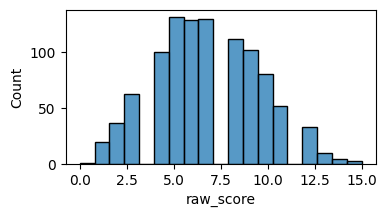

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

df["raw_score"] = df.sum(axis=1)

fig, ax = plt.subplots(figsize=[4,2])
sns.histplot(data=df, x="raw_score", ax=ax)

/tmp/ipykernel_22305/1755574120.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  d = df.groupby("raw_score_cat")[item_col].mean().reset_index()


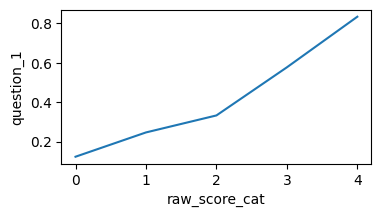

In [4]:
df["raw_score_cat"] = pd.qcut(df["raw_score"], q=5)

item_col = "question_1"
d = df.groupby("raw_score_cat")[item_col].mean().reset_index()
d["raw_score_cat"] = d["raw_score_cat"].cat.codes
fig, ax = plt.subplots(figsize=[4,2])
sns.lineplot(x="raw_score_cat", y=item_col, data=d, ax=ax)

del df["raw_score"]
del df["raw_score_cat"]

In [5]:
# 縦持ちへ変換
df_long = pd.melt(
    df.reset_index(),
    id_vars="index",
    var_name="item",
    value_name="response",
).rename(columns={"index": "user"})
df_long.head()

,user,item,response
0,user_1,question_1,0
1,user_2,question_1,1
2,user_3,question_1,0
3,user_4,question_1,0
4,user_5,question_1,1


#### モデルの定義

注意点として、$a$に非負制約をかけないとMCMCが収束しにくい（$\theta-b$の値と$a$の値次第で同値の尤度が出てきて一意に決まらないので）

`pm.LogNormal(mu=0.0, sigma=np.sqrt(0.5))` や `pm.HalfNormal` などが使われる事が多い様子


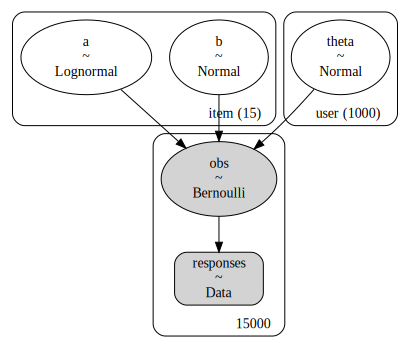

In [14]:
# indexと値の取得
user_idx, users = pd.factorize(df_long["user"])
item_idx, items = pd.factorize(df_long["item"])
responses = df_long["response"].to_numpy()

import pymc as pm
coords = {"user": df.index, "item": df.columns}
model = pm.Model(coords=coords)
with model:
    # 観測値の配列
    response_obs = pm.Data("responses", responses)

    # 2PLM
    a = pm.LogNormal("a", mu=0.0, sigma=np.sqrt(0.5), dims="item")
    # a = pm.HalfNormal("a", sigma=0.5, dims="item")
    b = pm.Normal("b", mu=0.0, sigma=1.0, dims="item")
    theta = pm.Normal("theta", mu=0.0, sigma=1.0, dims="user")
    obs = pm.Bernoulli("obs", p=pm.math.sigmoid(a[item_idx] * (theta[user_idx] - b[item_idx])), observed=response_obs)

g = pm.model_to_graphviz(model)
g

#### 推定

In [15]:
%%time
with model:
    idata = pm.sample(random_seed=0, draws=1000)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, theta]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 22 seconds.


CPU times: user 5.51 s, sys: 255 ms, total: 5.77 s
Wall time: 26 s


### EAP推定量

In [16]:
post_mean = idata.posterior.mean(dim=["chain", "draw"])

# 項目パラメータのEAP推定量
params_EAP = pd.DataFrame({
    "item": coords["item"],
    "a": post_mean["a"],
    "b": post_mean["b"],
})
params_EAP.head()

,item,a,b
0,question_1,1.188717,0.394483
1,question_2,0.635774,1.941949
2,question_3,0.918577,-0.091389
3,question_4,1.037007,0.334181
4,question_5,1.013821,-0.945100


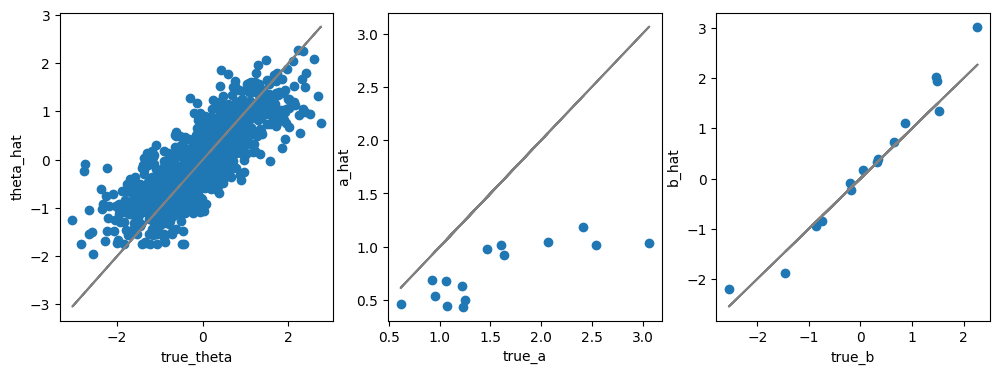

In [17]:
fig, axes = plt.subplots(figsize=[12,4], ncols=3)

ax = axes[0]
ax.scatter(true_thetas, post_mean["theta"])
ax.plot(true_thetas, true_thetas, color="gray")
_ = ax.set(xlabel="true_theta", ylabel="theta_hat")

ax = axes[1]
ax.plot(true_params[["a"]], true_params[["a"]], color="gray")
ax.scatter(true_params[["a"]], post_mean["a"])
_ = ax.set(xlabel="true_a", ylabel="a_hat")

ax = axes[2]
ax.plot(true_params[["b"]], true_params[["b"]], color="gray")
ax.scatter(true_params[["b"]], post_mean["b"])
_ = ax.set(xlabel="true_b", ylabel="b_hat")

### MAP推定量

In [10]:
with model:
    map_est = pm.find_MAP()

Output()

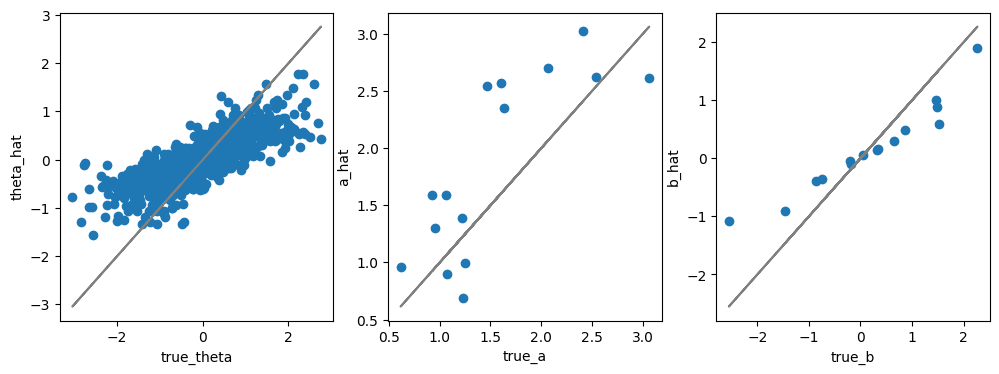

In [11]:
fig, axes = plt.subplots(figsize=[12,4], ncols=3)

ax = axes[0]
ax.scatter(true_thetas, map_est["theta"])
ax.plot(true_thetas, true_thetas, color="gray")
_ = ax.set(xlabel="true_theta", ylabel="theta_hat")

ax = axes[1]
ax.plot(true_params[["a"]], true_params[["a"]], color="gray")
ax.scatter(true_params[["a"]], map_est["a"])
_ = ax.set(xlabel="true_a", ylabel="a_hat")

ax = axes[2]
ax.plot(true_params[["b"]], true_params[["b"]], color="gray")
ax.scatter(true_params[["b"]], map_est["b"])
_ = ax.set(xlabel="true_b", ylabel="b_hat")

#### 事後分布

一部の項目の$a_j, b_j$

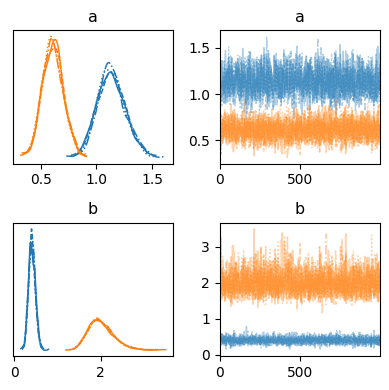

In [12]:
import matplotlib.pyplot as plt
import arviz as az

query = {"item": ["question_1", "question_2"]}

az.plot_trace(idata, coords=query, var_names=["a", "b"], figsize=[4, 4])
plt.tight_layout()
plt.show()

一部の回答者の$\theta_i$

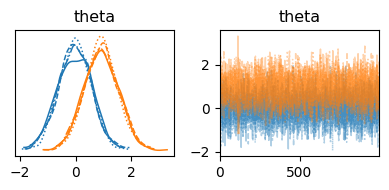

In [13]:
import matplotlib.pyplot as plt
import arviz as az

query = {"user": ["user_1", "user_2"]}

az.plot_trace(idata, coords=query, var_names=["theta"], figsize=[4, 2])
plt.tight_layout()
plt.show()